In [3]:
import os
import pandas as pd

# Folder containing your CSV files
folder_path = "/kaggle/input/dataset-gait"  # 🔁 Replace this with your actual folder name

# Initialize list to hold DataFrames
all_dfs = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['TestID'] = filename  # Optional: tag with filename or test ID
        all_dfs.append(df)

# Combine all into a single DataFrame
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"✅ Loaded {len(all_dfs)} files, total rows: {len(full_df)}")

✅ Loaded 10 files, total rows: 61703


In [6]:
import pandas as pd
import numpy as np
from pprint import pprint


# all_dfs = []
# for i in range(1, 11):
#     filename = f"labeled_gait_output_{i}.csv"
#     if os.path.exists(filename):
#         df = pd.read_csv(filename)
#         df['TestID'] = i  # optional: add a column to identify which test
#         all_dfs.append(df)
#     else:
#         print(f"⚠️ Missing file: {filename}")

# Combine all into one DataFrame
df = full_df


# Load the labeled dataset
# df = pd.read_csv("labeled_gait_output.csv")

# Initialize dictionary to store features
features = {}

# ---------------
# Time Features
# ---------------
features["duration_sec"] = (df["Time"].iloc[-1] - df["Time"].iloc[0]) / 1000.0

# ---------------
# Force Features
# ---------------
for side in ["Left", "Right"]:
    force_col = f"{side}_Force"
    features[f"{side}_force_mean"] = df[force_col].mean()
    features[f"{side}_force_std"] = df[force_col].std()
    features[f"{side}_force_range"] = df[force_col].max() - df[force_col].min()

# ---------------
# Joint Angle Features
# ---------------
for side in ["Left", "Right"]:
    angle_col = f"{side}_Ankle_Angle"
    features[f"{side}_angle_mean"] = df[angle_col].mean()
    features[f"{side}_angle_std"] = df[angle_col].std()
    features[f"{side}_angle_range"] = df[angle_col].max() - df[angle_col].min()
    features[f"{side}_angle_max"] = df[angle_col].max()
    features[f"{side}_angle_min"] = df[angle_col].min()

# ---------------
# Gait Phase Duration Features
# ---------------
for side in ["Left", "Right"]:
    phase_col = f"{side}_Gait_Phase"
    total_frames = len(df)
    phase_counts = df[phase_col].value_counts(normalize=True)  # % of time
    for phase in ["Stance", "Swing", "Heel Strike", "Toe-Off"]:
        features[f"{side}_phase_pct_{phase.replace(' ', '_')}"] = phase_counts.get(phase, 0.0) * 100

# ---------------
# Symmetry Features
# ---------------
def symmetry_index(val_left, val_right):
    return abs(val_left - val_right) / max((val_left + val_right) / 2, 1e-6) * 100

features["angle_symmetry_index"] = symmetry_index(
    features["Left_angle_mean"], features["Right_angle_mean"]
)
features["force_symmetry_index"] = symmetry_index(
    features["Left_force_mean"], features["Right_force_mean"]
)
features["stance_symmetry_index"] = symmetry_index(
    features["Left_phase_pct_Stance"], features["Right_phase_pct_Stance"]
)

# ---------------
# Print Final Feature Set
# ---------------
print("✅ Gait ML Features:")
pprint(features)


✅ Gait ML Features:
{'Left_angle_max': 4.220077767564014,
 'Left_angle_mean': -0.21636805891236036,
 'Left_angle_min': -6.493107399719546,
 'Left_angle_range': 10.713185167283559,
 'Left_angle_std': 1.8111423985686537,
 'Left_force_mean': 848.4450604978681,
 'Left_force_range': 3317.699715573002,
 'Left_force_std': 970.99245653616,
 'Left_phase_pct_Heel_Strike': 0.2641686789945384,
 'Left_phase_pct_Stance': 39.30765116769039,
 'Left_phase_pct_Swing': 60.16725280780513,
 'Left_phase_pct_Toe-Off': 0.2609273455099428,
 'Right_angle_max': 21.457046550116804,
 'Right_angle_mean': -0.5347642600098753,
 'Right_angle_min': -34.98024205985016,
 'Right_angle_range': 56.43728860996697,
 'Right_angle_std': 10.13061017362591,
 'Right_force_mean': 829.6827883679148,
 'Right_force_range': 3183.6901182473634,
 'Right_force_std': 911.3562128789434,
 'Right_phase_pct_Heel_Strike': 0.2657893457368361,
 'Right_phase_pct_Stance': 38.32876845534253,
 'Right_phase_pct_Swing': 61.15099752037988,
 'Right_phase

heel strike 0
stance 1
Swing 2
toe-off 3

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [9]:
# -------------------------------
# 1. Load Data
# -------------------------------
df = full_df

# Features from both sides for full-body context
features = [
    "LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered",
    "LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered",
    "LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered",
    "Left_Ankle_Angle", "Left_Force",
    "RT_GyroX_filtered", "RT_GyroY_filtered", "RT_GyroZ_filtered",
    "RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered",
    "RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered",
    "Right_Ankle_Angle", "Right_Force"
]

X = df[features]
y_raw = df["Left_Gait_Phase"]

In [10]:

# -------------------------------
# 2. Encode Labels
# -------------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_

In [11]:
print(df["Left_Gait_Phase"].value_counts())

Left_Gait_Phase
Swing          37125
Stance         24254
Heel Strike      163
Toe-Off          161
Name: count, dtype: int64


In [7]:
# -------------------------------
# 3. Split Data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
# -------------------------------
# 4. Define Classifiers
# -------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier  # Requires `pip install xgboost`

models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine (SVM)": SVC(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}



🔍 Training: Random Forest
✅ Accuracy: 0.9966
              precision    recall  f1-score   support

 Heel Strike       0.76      0.39      0.52        33
      Stance       1.00      1.00      1.00      4851
       Swing       1.00      1.00      1.00      7425
     Toe-Off       0.82      0.56      0.67        32

    accuracy                           1.00     12341
   macro avg       0.89      0.74      0.80     12341
weighted avg       1.00      1.00      1.00     12341



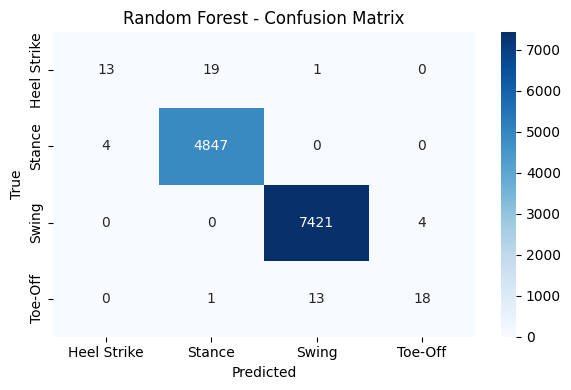


🔍 Training: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Accuracy: 0.8350
              precision    recall  f1-score   support

 Heel Strike       0.05      0.94      0.09        33
      Stance       0.95      0.84      0.89      4851
       Swing       0.98      0.83      0.90      7425
     Toe-Off       0.03      0.97      0.05        32

    accuracy                           0.84     12341
   macro avg       0.50      0.89      0.48     12341
weighted avg       0.97      0.84      0.89     12341



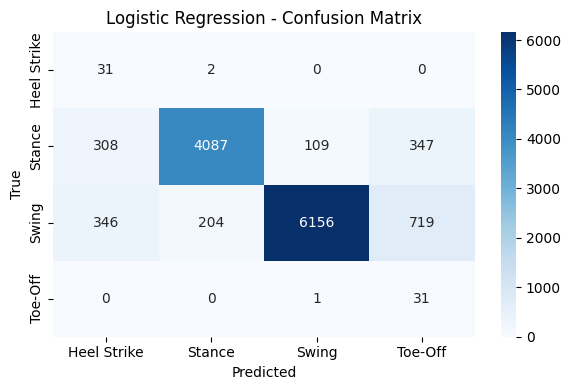


🔍 Training: K-Nearest Neighbors
✅ Accuracy: 0.9945
              precision    recall  f1-score   support

 Heel Strike       0.71      0.61      0.66        33
      Stance       0.99      1.00      0.99      4851
       Swing       1.00      1.00      1.00      7425
     Toe-Off       0.33      0.03      0.06        32

    accuracy                           0.99     12341
   macro avg       0.76      0.66      0.68     12341
weighted avg       0.99      0.99      0.99     12341



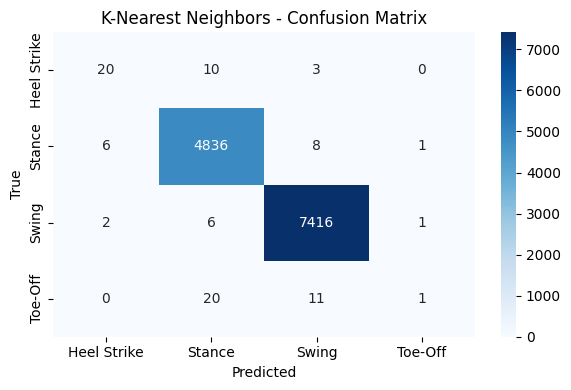


🔍 Training: Support Vector Machine (SVM)
✅ Accuracy: 0.9341
              precision    recall  f1-score   support

 Heel Strike       0.13      1.00      0.22        33
      Stance       0.98      0.94      0.96      4851
       Swing       0.99      0.93      0.96      7425
     Toe-Off       0.07      1.00      0.13        32

    accuracy                           0.93     12341
   macro avg       0.54      0.97      0.57     12341
weighted avg       0.98      0.93      0.96     12341



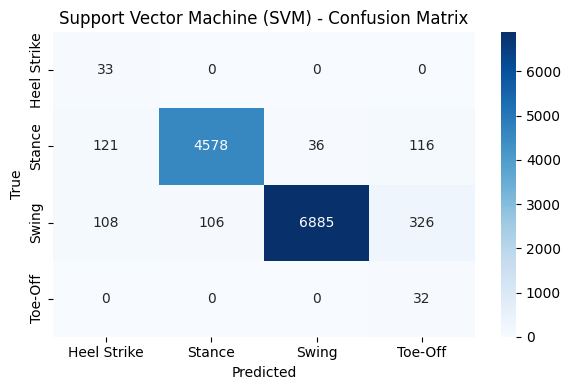


🔍 Training: Gradient Boosting
✅ Accuracy: 0.9942
              precision    recall  f1-score   support

 Heel Strike       0.46      0.52      0.49        33
      Stance       0.99      0.99      0.99      4851
       Swing       1.00      1.00      1.00      7425
     Toe-Off       0.72      0.72      0.72        32

    accuracy                           0.99     12341
   macro avg       0.79      0.81      0.80     12341
weighted avg       0.99      0.99      0.99     12341



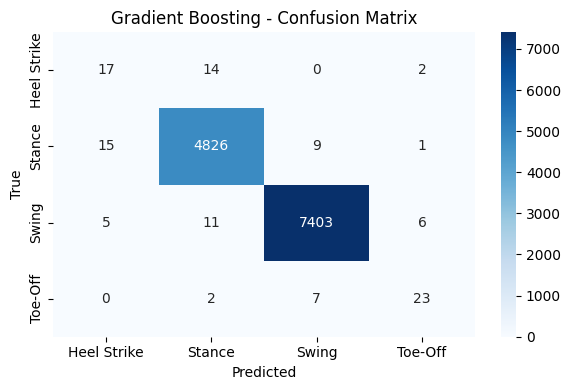


🔍 Training: Decision Tree
✅ Accuracy: 0.9956
              precision    recall  f1-score   support

 Heel Strike       0.70      0.64      0.67        33
      Stance       1.00      1.00      1.00      4851
       Swing       1.00      1.00      1.00      7425
     Toe-Off       0.74      0.81      0.78        32

    accuracy                           1.00     12341
   macro avg       0.86      0.86      0.86     12341
weighted avg       1.00      1.00      1.00     12341



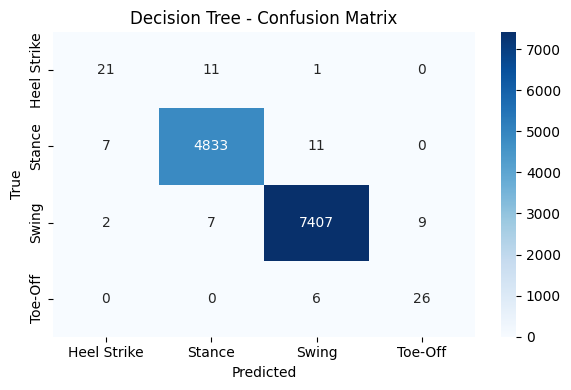


🔍 Training: Naive Bayes
✅ Accuracy: 0.9008
              precision    recall  f1-score   support

 Heel Strike       0.06      0.97      0.11        33
      Stance       0.92      0.89      0.90      4851
       Swing       0.97      0.91      0.94      7425
     Toe-Off       0.26      0.88      0.40        32

    accuracy                           0.90     12341
   macro avg       0.55      0.91      0.59     12341
weighted avg       0.94      0.90      0.92     12341



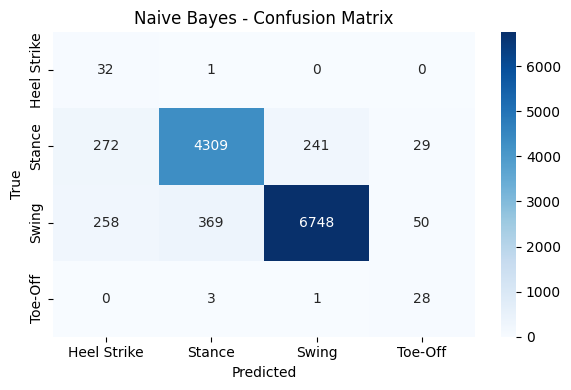


🔍 Training: AdaBoost
✅ Accuracy: 0.9131
              precision    recall  f1-score   support

 Heel Strike       0.00      0.00      0.00        33
      Stance       0.99      0.97      0.98      4851
       Swing       0.98      0.88      0.93      7425
     Toe-Off       0.02      0.47      0.03        32

    accuracy                           0.91     12341
   macro avg       0.50      0.58      0.48     12341
weighted avg       0.98      0.91      0.94     12341



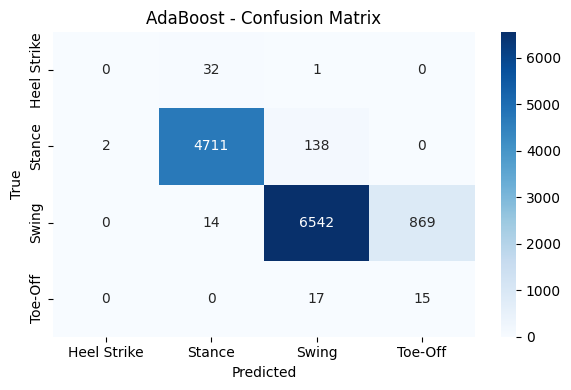


🔍 Training: XGBoost
✅ Accuracy: 0.9971
              precision    recall  f1-score   support

 Heel Strike       0.73      0.73      0.73        33
      Stance       1.00      1.00      1.00      4851
       Swing       1.00      1.00      1.00      7425
     Toe-Off       0.82      0.56      0.67        32

    accuracy                           1.00     12341
   macro avg       0.89      0.82      0.85     12341
weighted avg       1.00      1.00      1.00     12341



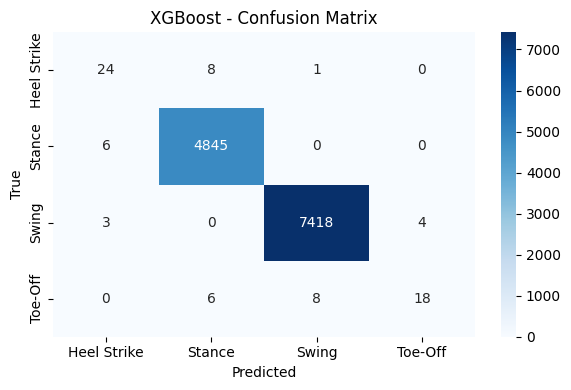

In [9]:
# -------------------------------
# 5. Train & Evaluate
# -------------------------------
for name, model in models.items():
    print(f"\n🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()